In [1]:
import os
import sys
sys.path.append('../ClusterExpansion/')
import cluster_expansion as ce
sys.path.append('../Netket/')
import analysis
import getpass
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd



In [2]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/extended_data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/extended_data_optimal_basis_rbm') if f.endswith('.h5')]
h5_files_opt.extend([os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')])
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

h5_files_raw = [os.path.join(f"{data_root}/data/data_rand", f) for f in os.listdir(f'{data_root}/data/data_rand') if f.endswith('.h5')]
df_raw = analysis.load_outputs_to_dataframe(h5_files_raw)
df_raw = analysis.attach_hypotheses_fields(df_raw, hypotheses)
df_raw["idx"] = df_raw["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_raw))


700
230


In [3]:
df_opt["gap"] = df_opt["exact_energies"].apply(lambda energies: (energies[1] - energies[0]) if energies is not None and len(energies) >= 2 else np.nan)
df_raw["gap"] = df_raw["exact_energies"].apply(lambda energies: (energies[1] - energies[0]) if energies is not None and len(energies) >= 2 else np.nan)   

In [4]:
def filter_dataframe_by_range(df, field, lower_bound, upper_bound):
    """
    Filters the DataFrame to include only rows where the specified field's values
    are within the given range (exclusive).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        field (str): The column name to filter by.
        lower_bound (float): The lower bound of the range (exclusive).
        upper_bound (float): The upper bound of the range (exclusive).

    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    return df[(df[field] > lower_bound) & (df[field] < upper_bound)]

In [5]:
df_opt.head()

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,alpha,...,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,idx,gap
0,"[(0.001594316+0.00026128103j), (0.0019582415+0...",[(0.0009954955736703908+0.0013113289131984377j...,0.000098,-71.024421,-71.017432,0.000244,"[-71.02442070162729, -63.78793225433999, -62.9...",[[(0.0009954955736703908+0.0013113289131984377...,../data/extended_data_optimal_basis_rbm/rbm_op...,1,...,1234,False,0.061492,0.000019,0.995577,10.888924,9.496602e-01,0.003814,64,7.236488
1,"[(0.012783367+0.011493065j), (0.0056239963+0.0...","[(0.002791813824433408-0.010850500553338981j),...",0.039124,-70.435420,-67.679675,0.748683,"[-70.43542044908015, -69.85256240545841, -68.3...",[[(0.002791813824433408-0.010850500553338981j)...,../data/extended_data_optimal_basis_rbm/rbm_op...,1,...,1234,False,1.632331,0.000040,0.987307,10.122140,4.241686e-02,0.003343,517,0.582858
2,"[(-0.0007782893+0.00010637795j), (-0.001168144...",[(-0.0005199615799536722+0.0005521744700001152...,0.000247,-95.278030,-95.254535,0.000570,"[-95.27802978634708, -82.68212591992203, -81.2...",[[(-0.0005199615799536722+0.000552174470000115...,../data/extended_data_optimal_basis_rbm/rbm_op...,1,...,1234,False,1.679316,0.000019,0.995643,10.893352,9.146015e-01,0.003811,90,12.595904
3,"[(-2.3994104e-05-1.8422288e-06j), (-2.5061283e...",[(1.6058570343981723e-06+8.361575780876816e-07...,0.066666,-65.986906,-61.587820,0.734045,"[-65.98690582771678, -64.02086700137522, -63.6...",[[(1.6058570343981723e-06+8.361575780876816e-0...,../data/extended_data_optimal_basis_rbm/rbm_op...,1,...,1234,False,1.818953,0.000871,0.916249,7.045995,5.942697e-09,0.002244,321,1.966039
4,"[(0.003819013-0.0013188006j), (0.00012150649+0...",[(-0.0020855275441021117-0.0050953942711789435...,0.002724,-67.941489,-67.756444,0.524908,"[-67.94148920561122, -67.88676887324011, -65.9...",[[(-0.0020855275441021117-0.005095394271178943...,../data/extended_data_optimal_basis_rbm/rbm_op...,1,...,1234,False,1.797957,0.000029,0.994329,10.453560,3.780565e-06,0.003512,170,0.054720


[]


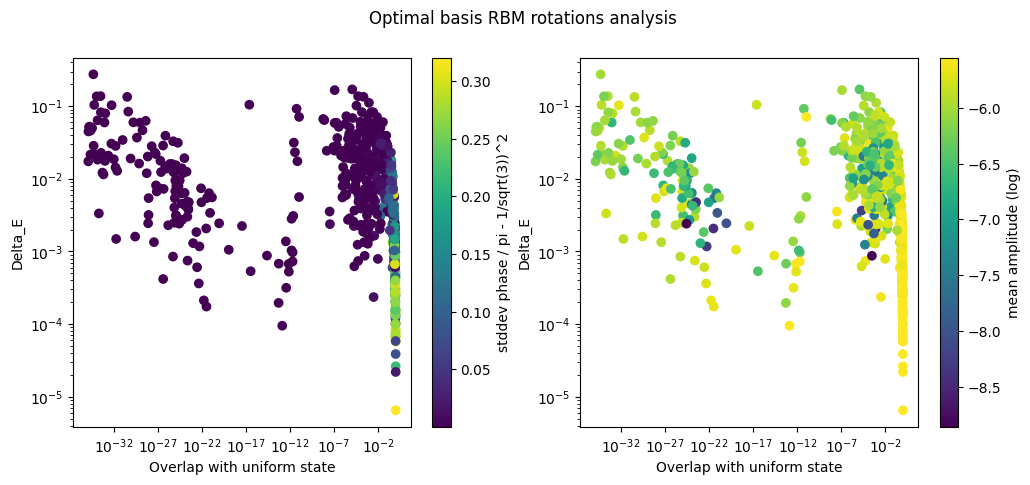

In [6]:
%matplotlib inline
# Scatter each hypothesis value vs the measured infidelity (uses df_eval if present)
df_rot_filter = df_opt
infidelity_ansatz_overlap = [abs(sum(psi_1))**2 / len(psi_1) for psi_1 in df_rot_filter.psi_0.values]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=(df_rot_filter.std_phase/np.pi - 1./np.sqrt(3))**2, cmap='viridis')
ax[0].set_xlabel("Overlap with uniform state")
ax[0].set_ylabel("Delta_E")
m = ax[0].collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax[0])
cbar0.set_label('stddev phase / pi - 1/sqrt(3))^2')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=np.log(df_rot_filter.mean_amplitude), cmap='viridis')
ax[1].set_xlabel("Overlap with uniform state")
ax[1].set_ylabel("Delta_E")
m1 = ax[1].collections[-1]  # get the scatter collection just created
cbar1 = fig.colorbar(m1, ax=ax[1])
cbar1.set_label('mean amplitude (log)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')


# ax[0].legend()
fig.suptitle("Optimal basis RBM rotations analysis")
handles, labels = ax[0].get_legend_handles_labels()
print(labels)


[]


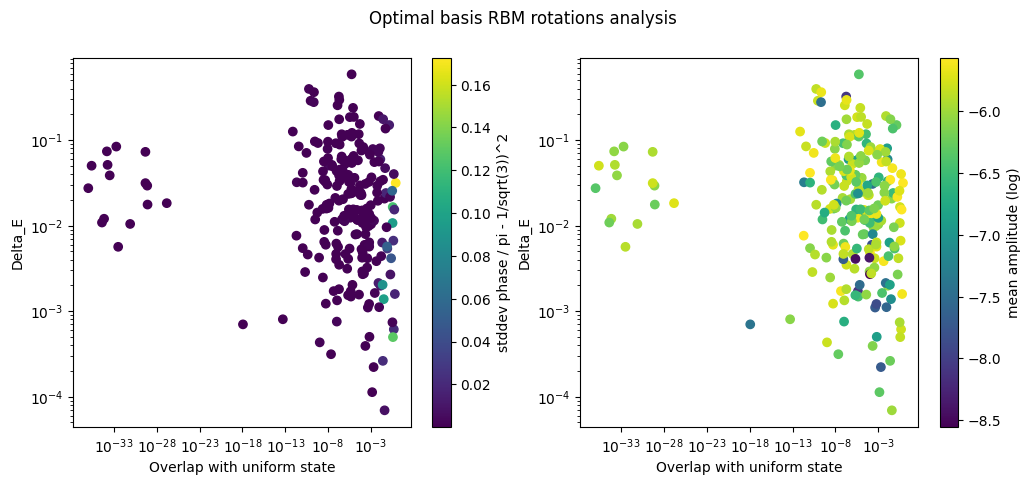

In [8]:
%matplotlib inline
# Scatter each hypothesis value vs the measured infidelity (uses df_eval if present)
df_rot_filter = df_raw
infidelity_ansatz_overlap = [abs(sum(psi_1))**2 / len(psi_1) for psi_1 in df_rot_filter.psi_0.values]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=(df_rot_filter.std_phase/np.pi - 1./np.sqrt(3))**2, cmap='viridis')
ax[0].set_xlabel("Overlap with uniform state")
ax[0].set_ylabel("Delta_E")
m = ax[0].collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax[0])
cbar0.set_label('stddev phase / pi - 1/sqrt(3))^2')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=np.log(df_rot_filter.mean_amplitude), cmap='viridis')
ax[1].set_xlabel("Overlap with uniform state")
ax[1].set_ylabel("Delta_E")
m1 = ax[1].collections[-1]  # get the scatter collection just created
cbar1 = fig.colorbar(m1, ax=ax[1])
cbar1.set_label('mean amplitude (log)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')


# ax[0].legend()
fig.suptitle("Optimal basis RBM rotations analysis")
handles, labels = ax[0].get_legend_handles_labels()
print(labels)


In [9]:
import pandas as pd

def align_df2_to_df1_idx(df1, df2, key='idx', keep_extra=True, drop_missing=False):
    """
    Return a reordered copy of df2 so its rows with 'key' appear in the same order
    as in df1.

    Parameters:
        df1, df2 : pandas.DataFrame
            Input dataframes (both must contain column `key`).
        key : str
            Column name used for alignment (default 'idx').
        keep_extra : bool
            If True, rows in df2 whose key is not present in df1 are appended at the end.
        drop_missing : bool
            If True, keys present in df1 but missing in df2 are omitted from the result.
            If False, those positions will appear as rows with NaNs (unless df2 had them).

    Returns:
        pandas.DataFrame : reordered copy of df2
    """
    if key not in df1.columns:
        raise KeyError(f"{key!r} not found in df1")
    if key not in df2.columns:
        raise KeyError(f"{key!r} not found in df2")

    order = list(df1[key].values)
    df2_idx = df2.set_index(key)

    if drop_missing:
        aligned = df2_idx.reindex(order).dropna(how='all').reset_index()
    else:
        aligned = df2_idx.reindex(order).reset_index()

    if keep_extra:
        extras = df2[~df2[key].isin(order)]
        if not extras.empty:
            aligned = pd.concat([aligned, extras], ignore_index=True, sort=False)

    return aligned

# Example usage:
# df2_ordered = align_df2_to_df1_idx(df_opt, df_raw)  # reorder df_raw to match df_opt idx order

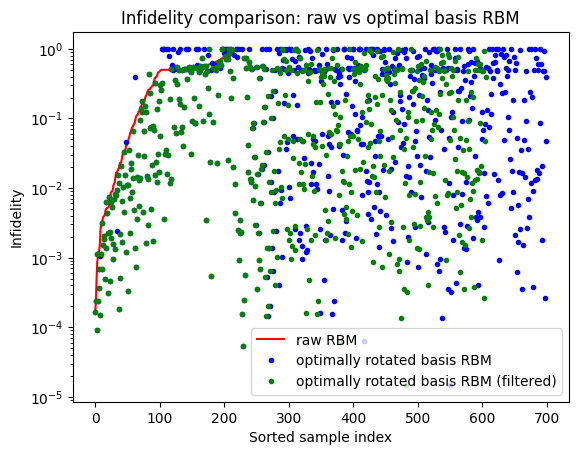

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='infidelity')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
filt_sortedopt = filter_dataframe_by_range(sortedopt, 'uniform_state_overlap', 1e-10,1.0)
filt_sortedopt = align_df2_to_df1_idx(sorteddraw, filt_sortedopt, 'idx')

ax.plot(sorteddraw.infidelity.values, c='red',label='raw RBM')
ax.plot(sortedopt.infidelity.values, c='blue', marker='.',ls='None', label='optimally rotated basis RBM')
ax.plot(filt_sortedopt.infidelity.values, c='green', marker='.',ls='None', label='optimally rotated basis RBM (filtered)')
ax.set_title("Infidelity comparison: raw vs optimal basis RBM")
ax.set_ylabel("Infidelity")
ax.set_xlabel("Sorted sample index")
ax.legend() 

In [11]:
def infidelity_ansatz_overlap(psi_0_list):
    """
    Calculates the overlap with the uniform state for a list of wavefunctions.

    Parameters:
        psi_0_list (iterable): An iterable of wavefunctions (each a numpy array or list of amplitudes).

    Returns:
        list: Overlap values for each wavefunction.
    """
    return [abs(np.sum(psi_0))**2 / len(psi_0) for psi_0 in psi_0_list]

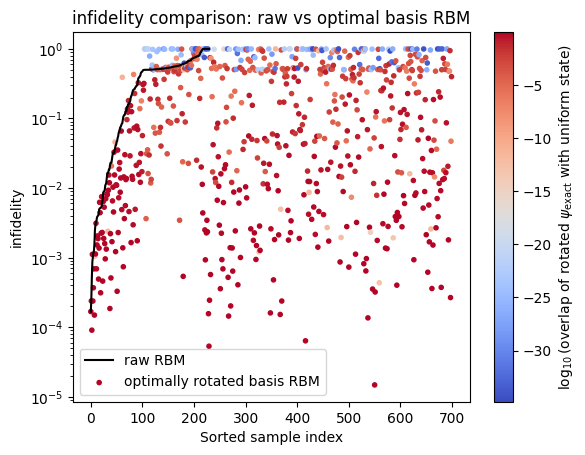

In [12]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='infidelity')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
ax.plot(sorteddraw.infidelity.values, c='black',label='raw RBM')
ax.scatter(np.arange(len(sortedopt.infidelity.values)), sortedopt.infidelity.values, 
          c=np.log10(infidelity_ansatz_overlap(sortedopt.psi_0)), 
          cmap='coolwarm', marker='.', label='optimally rotated basis RBM')

m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(overlap of rotated $\psi_{\mathrm{exact}}$ with uniform state)')

ax.set_title("infidelity comparison: raw vs optimal basis RBM")
ax.set_ylabel("infidelity")
ax.set_xlabel("Sorted sample index")
ax.legend() 


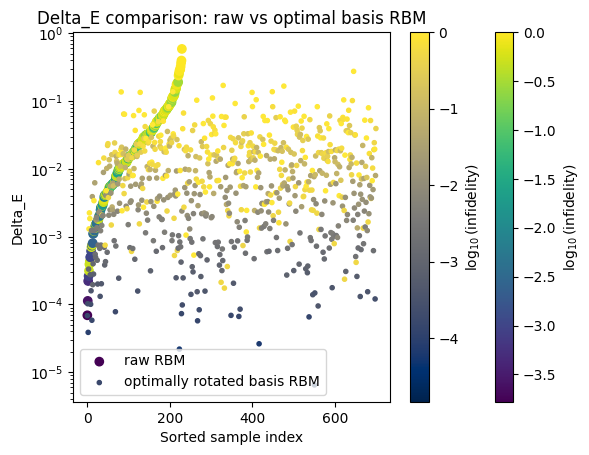

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='Delta_E')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
ax.scatter(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        c=np.log10(sorteddraw.infidelity.values), cmap='viridis', label='raw RBM')
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')




ax.scatter(np.arange(len(sortedopt.Delta_E.values)), sortedopt.Delta_E.values, 
          c=np.log10(sortedopt.infidelity.values), 
          cmap='cividis', marker='.', label='optimally rotated basis RBM')
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')

ax.set_title("Delta_E comparison: raw vs optimal basis RBM")
ax.set_ylabel("Delta_E")
ax.set_xlabel("Sorted sample index")
ax.legend() 

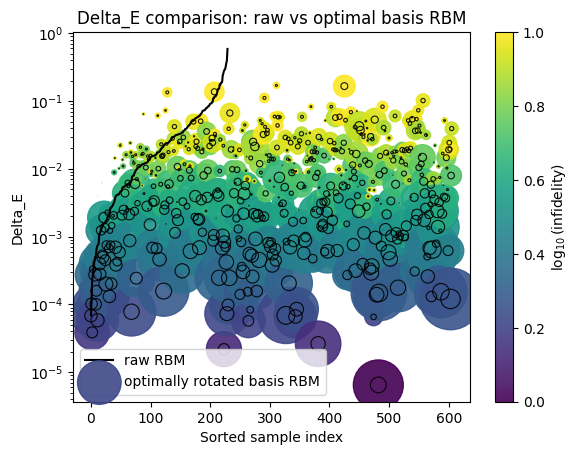

In [14]:
%matplotlib inline
def energy_gap(df):
    gaps = []
    for energies in df['exact_energies']:
        if energies is not None and len(energies) >= 2:
            gap = energies[1] - energies[0]
        else:
            gap = np.nan  # or some other placeholder for missing data
        gaps.append(gap)
    return gaps

fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='Delta_E')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
filt_sortedopt = align_df2_to_df1_idx(sorteddraw, filt_sortedopt, 'idx')
# ax.scatter(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        # c=np.log10(sortedopt.gap.values), cmap='inferno', label='raw RBM')
ax.plot(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        c="black", label='raw RBM')
# m = ax.collections[-1]  # get the scatter collection just created
# cbar0 = fig.colorbar(m, ax=ax)
# cbar0.set_label(r'$\log_{10}$(gap)')

maxgapratio = np.max(np.abs(filt_sortedopt.gap.values/filt_sortedopt.E_exact.values))
gapratio = np.abs(filt_sortedopt.gap.values/filt_sortedopt.E_exact.values)

ax.scatter(np.arange(len(filt_sortedopt.Delta_E.values)), filt_sortedopt.Delta_E.values, 
          c=np.log10(filt_sortedopt.infidelity.values), 
          cmap='viridis', marker='o', label='optimally rotated basis RBM', s=100*(np.abs(filt_sortedopt.gap.values)),alpha=0.9)
ax.scatter(np.arange(len(filt_sortedopt.Delta_E.values)), filt_sortedopt.Delta_E.values,
           marker='o', edgecolors='black', facecolors='none',
           s=10 * (np.abs(filt_sortedopt.gap.values)), linewidths=0.8, alpha=0.9)
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')

ax.set_title("Delta_E comparison: raw vs optimal basis RBM")
ax.set_ylabel("Delta_E")
ax.set_xlabel("Sorted sample index")
ax.legend() 

In [15]:
sortedopt.head()

,idx,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,...,out,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,gap
0,838,"[(0.0024359243+0.0031992274j), (0.002557759+0....",[(-0.0034252757004983015-0.0019603367094534036...,0.000068,-68.817924,-68.813218,0.000167,"[-68.81792421480071, -60.80580428310742, -60.3...",[[(-0.0034252757004983015-0.001960336709453403...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,0.176329,0.000019,0.995792,10.892416,9.540043e-01,0.003822,8.012120
1,997,"[(0.00266061-0.0029088717j), (0.0028396137-0.0...",[(-0.0034440515105044664+0.0020550889497098247...,0.000103,-57.928155,-57.922217,0.000238,"[-57.9281552705367, -51.072793589146286, -50.0...",[[(-0.0034440515105044664+0.002055088949709824...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,1.405727,0.000017,0.997282,10.964002,9.472633e-01,0.003847,6.855362
2,888,"[(-0.00026114928+0.002674608j), (-0.0005553632...",[(-0.0024487636718072557+0.0011072490058719635...,0.000039,-63.104504,-63.102058,0.000090,"[-63.10450444171446, -56.924565590625996, -55....",[[(-0.0024487636718072557+0.001107249005871963...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,2.692010,0.000016,0.999324,11.058784,9.750624e-01,0.003891,6.179939
3,1,"[(0.018178806-0.00016717562j), (0.011473363-0....","[(-0.013435672843449138+0.01407718758399147j),...",0.000333,-59.347367,-59.327627,0.001113,"[-59.34736709702083, -57.162323104129776, -56....",[[(-0.013435672843449138+0.01407718758399147j)...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,0.092658,0.000022,0.992489,10.741295,9.131624e-01,0.003749,2.185044
4,876,"[(-0.0001155107+0.00028950378j), (-0.000325498...",[(1.5004958629694588e-15+1.7223654030218835e-1...,0.001303,-65.179344,-65.094431,0.998649,"[-65.17934389860874, -65.18346362181418, -55.5...",[[(1.5004958629694588e-15+1.7223654030218835e-...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,1.836834,0.004501,0.695800,5.403504,1.028352e-23,0.001200,-0.004120


In [16]:
len(sortedopt), len(filt_sortedopt)

(700, 606)

In [ ]:
def plotCorrelations(df_eval, hypotheses, plt_fig=None, text_offset=None, color="black", alphamod=1., ylog=False, xlog=False, pearson=False, logpearson=False):
    scatter_size = 10
    N = len(hypotheses)
    if plt_fig is None:
        fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
        gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)
        axes = np.empty((3, N), dtype=object)
        for row in range(3):
            for col in range(N):
                axes[row, col] = fig.add_subplot(gs[row, col])
        bottom_right_ax = fig.add_subplot(gs[-1, -1])
        
    else:
        fig = plt_fig
        all_axes = fig.get_axes()
        axes = np.array(all_axes[:3*N]).reshape(3, N)
        bottom_right_ax = all_axes[-1]
        # The last axis (all_axes[3*N]) is the colorbar or extra axis

    for idx, name in enumerate(hypotheses.keys()):
        if name == "mean_phase":
            data = df_eval[name].abs()
            title = f"|{name}|"
        else:
            data = df_eval[name]
            title = name
        axes[0, idx].hist(data, bins=30, color=color,alpha = alphamod)
        axes[0, idx].set_title(title)
        if idx == 0:
            axes[0, 0].set_ylabel("Count")
        else:
            axes[0, idx].tick_params(axis='y', labelleft=False)

        scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], alpha=0.3*alphamod, s=scatter_size, color=color)
        if idx == 0:
            axes[1, 0].set_ylabel("Energy Error")
        else:
            axes[1, idx].tick_params(axis='y', labelleft=False)
        axes[2, idx].scatter(data, df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
        axes[2, idx].set_xlabel(title)
        if idx == 0:
            axes[2, 0].set_ylabel("Infidelity")
        else:
            axes[2, idx].tick_params(axis='y', labelleft=False)

        if ylog:
            # apply log scale to y-axis for all three rows for this column
            axes[0, idx].set_yscale('log')
            axes[1, idx].set_yscale('log')
            axes[2, idx].set_yscale('log')
        if xlog:
            axes[0, idx].set_xscale('log')
            axes[1, idx].set_xscale('log')
            axes[2, idx].set_xscale('log')
        from scipy.stats import pearsonr
        if pearson:
            r_deltaE, _ = pearsonr(data, df_eval["Delta_E"])
            r_infidelity, _ = pearsonr(data, df_eval["infidelity"])

            axes[1, idx].text(0.00, 0.95, f"r={r_deltaE:.2f}", transform=axes[1, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
            axes[2, idx].text(0.00, 0.95, f"r={r_infidelity:.2f}", transform=axes[2, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
        if logpearson:
            r_deltaE, _ = pearsonr(data, np.log(df_eval["Delta_E"]))
            r_infidelity, _ = pearsonr(data, np.log(df_eval["infidelity"]))

            axes[1, idx].text(0.00, 0.9, f"r={r_deltaE:.2f}", transform=axes[1, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
            axes[2, idx].text(0.00, 0.9, f"r={r_infidelity:.2f}", transform=axes[2, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
    plt.tight_layout()

    bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])
    bottom_right_ax.tick_params(axis='y', labelleft=False)
    bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
    bottom_right_ax.set_xlabel("Delta_E")
    if ylog:
        bottom_right_ax.set_yscale('log')
    if text_offset is None:
        text_offset = [0,0]
        if plt_fig is not None:
            text_offset = [0.0,-0.15]
    text_pos = np.array([0.1, 0.95]) + np.array(text_offset)
    axes[0, 0].text(*text_pos, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, fontsize=10, color=color, ha="left", va="top")
    return fig

hyptheses_trim = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
}
infidelityrange = (0,1)
df_eval = filter_dataframe_by_range(filt_sortedopt, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_eval,hyptheses_trim,ylog=True,xlog=False,pearson=True)

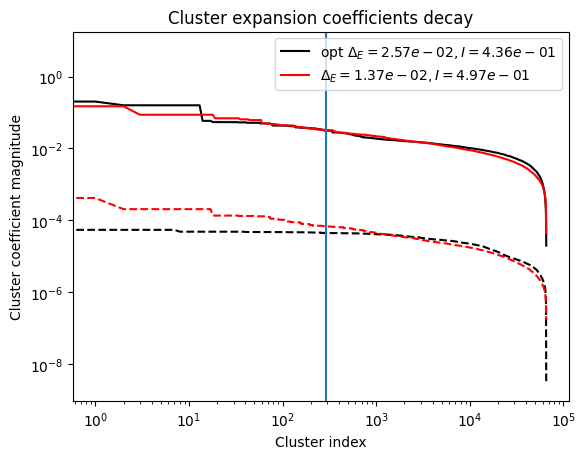

In [18]:
import netket as nk

def sort_normalize(v):
    vs = np.sort(np.abs(v))[::-1]
    # return vs / np.linalg.norm(vs)
    return vs #/ vs[0]

H_index = 215
psi = df_opt.psi_0.values[H_index]
hilbert = nk.hilbert.Spin(1/2, N=16)
cumulant_coeffs = sort_normalize(ce.fwht_coeffs_in_cluster_col_order( np.log(psi), hilbert))
plt.plot(cumulant_coeffs,'-',label = "opt $\\Delta_E = {:.2e}, I = {:.2e}$".format(df_opt.Delta_E.values[H_index], df_opt.infidelity.values[H_index]),color = "black")
cluster_coeffs = sort_normalize(ce.fwht_coeffs_in_cluster_col_order( psi, hilbert))
plt.plot(cluster_coeffs,'--',color = "black")

psi = df_raw.psi_0.values[H_index]
cumulant_coeffs = sort_normalize(ce.fwht_coeffs_in_cluster_col_order( np.log(psi), hilbert))
plt.plot(cumulant_coeffs,'-',label = "$\\Delta_E = {:.2e}, I = {:.2e}$".format(df_raw.Delta_E.values[H_index], df_raw.infidelity.values[H_index]),color = "red")
cluster_coeffs = sort_normalize(ce.fwht_coeffs_in_cluster_col_order( psi, hilbert))
plt.plot(cluster_coeffs,'--',color = "red")

plt.xlabel("Cluster index")
plt.ylabel("Cluster coefficient magnitude")
plt.xscale("log")
plt.yscale("log")
plt.title("Cluster expansion coefficients decay")
plt.legend()
plt.axvline(x=16**2+32)
plt.show()

/tmp/ipykernel_1616059/252430091.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


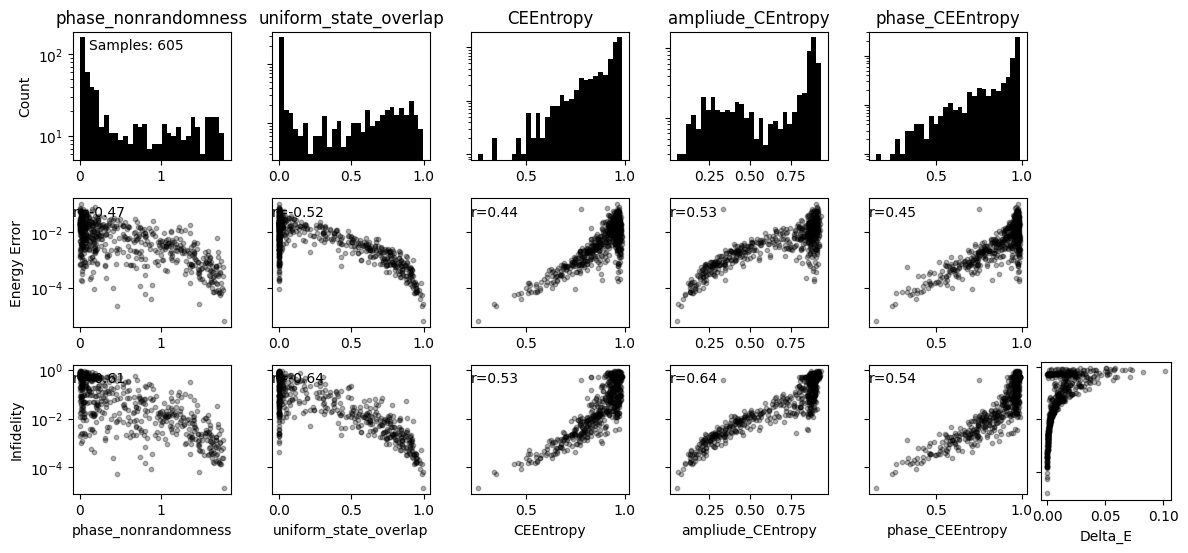

In [30]:
def relative_weights(v, max_N):
    vs = np.sort(np.abs(v))[::-1]
    return np.sum(vs[1:max_N]) /  vs[0]
    # return np.sum(vs[max_N+1:-1]) /  np.sum(vs[0:max_N])

def cluster_expansion_decay(logpsi,hilbert, max_N):
    """
    estimates the decay of cluster expansion coefficients by expanding logpsi = W + \\sum_i c_i \\sigma_i + \\sum_{i<j} c_{ij} \\sigma_i \\sigma_j + .... for the max_N most significant terms
    """
    cluster_coeffs_test_exact = ce.fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
    sorted_c = sort_normalize(cluster_coeffs_test_exact)
    relweights = relative_weights(sorted_c, max_N)

    return relweights

# Define the CEdecay lambda function
# CEdecay = lambda x: cluster_expansion_decay(np.log(x), nk.hilbert.Spin(1/2, N=16), max_N=16**2+32)
def CEdecay(psi):
    hilbert = nk.hilbert.Spin(1/2, N=16)
    ce1 = cluster_expansion_decay(np.log(psi), hilbert, max_N=16**2+32)
    return ce1
    # ce2 = cluster_expansion_decay(psi, hilbert, max_N=16**2+32)
    # return np.min([ce1, ce2])

def CEEntropy(logpsi):
    hilbert = nk.hilbert.Spin(1/2, N=16)

    ce1 = ce.fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
    sorted_c = sort_normalize(ce1)
    sorted_c = sorted_c / np.sum(sorted_c)
    num_c = len(sorted_c)
    return -1/np.log(num_c) * np.sum(sorted_c * np.log(sorted_c))
    # ce2 = cluster_expansion_decay(psi, hilbert, max_N=16**2+32)
    # return np.min([ce1, ce2])

def min_CEEntropy(psi):
    return min(CEEntropy(psi), CEEntropy(np.log(psi)),CEEntropy(np.sqrt(psi)), CEEntropy(np.sqrt(psi)),  CEEntropy(np.exp(psi)) )
# Ensure the hypotheses dictionary includes the CEdecay function
def amplitude_CEEntropy(psi):
    return CEEntropy(np.log(np.abs(psi)))
def phase_CEEntropy(psi):
    return CEEntropy(np.sign(psi))

def phase_nonrandomness(psi):
    sigma = std_phase(psi)
    return np.abs(sigma - np.pi/np.sqrt(3))

def prod_CE_entropy(psi):
    aE = amplitude_CEEntropy(psi)
    pE = phase_CEEntropy(psi)
    return min(aE*pE,aE,pE)

hyptheses_CC = {
    "phase_nonrandomness": phase_nonrandomness,
    # "IPR": ipr,
    # "SPCA": pca_entropy,
    "uniform_state_overlap": uniform_state_overlap,
    "CEEntropy": CEEntropy,
    "ampliude_CEntropy" : amplitude_CEEntropy,
    "phase_CEEntropy" : phase_CEEntropy,
    # "prod_CE_entropy" : prod_CE_entropy,
    # "min_CEEntropy": min_CEEntropy,
}
# Filter the dataframe and plot correlations
infidelityrange = (0, 0.9)
df_eval = filter_dataframe_by_range(df_opt, 'infidelity', *infidelityrange).copy()
# df_eval = filter_dataframe_by_range(df_eval, 'uniform_state_overlap', 0.05,1.0).copy()
# df_eval = df_eval.head(100)
df_eval = analysis.attach_hypotheses_fields(df_eval, hyptheses_CC)
plt_fig = plotCorrelations(df_eval, hyptheses_CC, ylog=True, xlog=False, pearson=True)

In [ ]:
def fwht_coeffs_in_cluster_col_order_2(logpsi, hilbert):
    """Compute coefficients c solving H c = logpsi using FWHT.
   Usage: fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
   where logpsi is a vector of log wavefunction amplitudes in the canonical netket ordering.   
    """
    n_sites = hilbert.size
    hstates = np.array(hilbert.all_states())  # shape (n_states, n_sites) with values +1/-1
    import sympy 
    import itertools
    import jax.numpy as jnp
    # Map spins s in {+1,-1} -> bits b in {0,1} with convention b=1 when s==-1
    b = ((1 - hstates) // 2).astype(np.int64)
    powers = (1 << np.arange(n_sites)).astype(np.int64)
    indices = (b * powers).sum(axis=1)
    perm = np.argsort(indices)  # mapping FWHT index -> row

    psi_arr = jnp.array(logpsi)
    psi_by_index = psi_arr[perm]
    n = psi_by_index.shape[0]
    coeffs_by_index = np.array(sympy.fwht(np.array(psi_by_index))) / float(n)  # Convert JAX array to NumPy array
    coeffs_by_index_np = np.array(coeffs_by_index)

    # Build mask list in the SAME ORDER as optim_cluster_expansion_extreme columns
    masks = [0]
    for cluster_size in range(1, n_sites + 1):
        for comb in itertools.combinations(range(n_sites), cluster_size):
            mask = 0
            for bpos in comb:
                mask |= (1 << bpos)
            masks.append(mask)
    masks = np.array(masks, dtype=np.int64)  # length n

    # coeffs in column order: take coeffs_by_index[mask] for each column
    coeffs_col_order = coeffs_by_index_np[masks]
    return coeffs_col_order

hilbert = nk.hilbert.Spin(1/2, N=12)
psi = df_opt.psi_0.values[0]
ce1 = fwht_coeffs_in_cluster_col_order_2( np.log(psi[0:2**12-1]), hilbert)
ce2 = ce.fwht_coeffs_in_cluster_col_order( np.log(psi[0:2**12-1]), hilbert)
np.allclose(ce1, ce2)

True

In [ ]:
hilbert = nk.hilbert.Spin(1/2, N=12)
ce1 = fwht_coeffs_in_cluster_col_order_2( np.log(psi[0:2**12-1]), hilbert)

In [ ]:
hilbert = nk.hilbert.Spin(1/2, N=16)
# psi = df_opt.psi_0.values[0]
ce2 = [ce.fwht_coeffs_in_cluster_col_order( np.log(psi), hilbert) for psi in df_opt.psi_0.values]